## Deep-Visual Semantic Allignments for Generating Image Descriptions
### By Karpathy et al.

In [1]:
!python3 --version

Python 3.8.10


In [2]:
torch.cuda.empty_cache()

NameError: name 'torch' is not defined

In [2]:
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import pickle
import os

In [5]:
from vocabulary import build_vocab, Vocabulary
from dataset import FlickrDataset, collate_fn
from model import AlignmentEncoderCNN, GenerativeEncoderCNN, EncoderBRNN, DecoderMRNN
from train import train_alignment_epoch, train_generative_epoch
from inference import generate_region_captions
from evaluate import evaluate_model

In [6]:
DATA_DIR = 'data/'
CAPTIONS_FILE = os.path.join(DATA_DIR, 'captions.txt')
TOKENS_FILE = os.path.join(DATA_DIR, 'tokens.txt')
VOCAB_FILE = os.path.join(DATA_DIR, 'vocab.pkl')
MODEL_DIR = 'saved_models/'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [7]:
# Hyperparameters
embed_size = 1024
hidden_size = 512
num_layers_brnn = 1
num_layers_mrnn = 1
vocab_threshold = 5
batch_size = 4 # Reduced for memory with YOLO
num_epochs_alignment = 10
num_epochs_generative = 20
lr_alignment = 1e-4
lr_generative = 1e-4

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
if not os.path.exists(VOCAB_FILE):
    print("Building vocabulary...")
    vocab = build_vocab(TOKENS_FILE, threshold=vocab_threshold)
    with open(VOCAB_FILE, 'wb') as f:
        pickle.dump(vocab, f)
    print(f"Vocabulary built and saved to {VOCAB_FILE}")
else:
    print("Loading vocabulary...")
    with open(VOCAB_FILE, 'rb') as f:
        vocab = pickle.load(f)
    print(f"Vocabulary loaded. Size: {len(vocab)}")

Loading vocabulary...
Vocabulary loaded. Size: 2892


In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Dataloader for Alignment Model Training
print("Creating dataloader for alignment model...")
alignment_dataset = FlickrDataset(root_dir=DATA_DIR, captions_file=CAPTIONS_FILE, vocab=vocab, transform=transform, stage='alignment')
alignment_loader = DataLoader(alignment_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

# Dataloader for Generative Model Training
print("Creating dataloader for generative model...")
generative_dataset = FlickrDataset(root_dir=DATA_DIR, captions_file=CAPTIONS_FILE, vocab=vocab, transform=transform, stage='generative')
generative_loader = DataLoader(generative_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)


Creating dataloader for alignment model...


Using cache found in /home/ivlabs/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-9-30 Python-3.8.10 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 11936MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Creating dataloader for generative model...


In [11]:
# Alignment Models
align_encoder_cnn = AlignmentEncoderCNN(embed_size).to(device)
encoder_brnn = EncoderBRNN(embed_size, hidden_size, len(vocab), num_layers_brnn).to(device)

# Generative Models
gen_encoder_cnn = GenerativeEncoderCNN(embed_size).to(device)
decoder_mrnn = DecoderMRNN(embed_size, hidden_size, len(vocab), num_layers_mrnn).to(device)

align_encoder_cnn.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'align_encoder_cnn.pth')))
encoder_brnn.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'encoder_brnn.pth')))
gen_encoder_cnn.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'gen_encoder_cnn.pth')))
decoder_mrnn.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'decoder_mrnn.pth')))

/tmp/ipykernel_3888951/4182126340.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  align_encoder_cnn.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'align_encoder_cnn

<All keys matched successfully>

In [ ]:
params = list(align_encoder_cnn.classifier.parameters()) + list(encoder_brnn.parameters())
optimizer_alignment = optim.Adam(params, lr=lr_alignment)

for epoch in range(1, num_epochs_alignment + 1):
    loss = train_alignment_epoch(align_encoder_cnn, encoder_brnn, alignment_loader, optimizer_alignment, device)
    print(f"Epoch [{epoch}/{num_epochs_alignment}], Alignment Loss: {loss:.4f}")

# Save the trained alignment models
torch.save(align_encoder_cnn.state_dict(), os.path.join(MODEL_DIR, 'align_encoder_cnn.pth'))
torch.save(encoder_brnn.state_dict(), os.path.join(MODEL_DIR, 'encoder_brnn.pth'))
print("Saved alignment models.")

In [ ]:
import warnings
warnings.filterwarnings("ignore")

gen_encoder_cnn.load_state_dict(align_encoder_cnn.state_dict())
print("Loaded weights from alignment encoder into generative encoder.")

criterion_generative = nn.CrossEntropyLoss()

params = list(decoder_mrnn.parameters()) + list(gen_encoder_cnn.classifier.parameters())
optimizer_generator = optim.Adam(params, lr=lr_generative)

for epoch in range(1, num_epochs_generative + 1):
    loss = train_generative_epoch(gen_encoder_cnn, decoder_mrnn, generative_loader, optimizer_generator, criterion_generative, device)
    print(f"Epoch [{epoch}/{num_epochs_generative}], Generative Loss: {loss:.4f}")

# Save the trained alignment models
torch.save(gen_encoder_cnn.state_dict(), os.path.join(MODEL_DIR, 'gen_encoder_cnn.pth'))
torch.save(decoder_mrnn.state_dict(), os.path.join(MODEL_DIR, 'decoder_mrnn.pth'))
print("Saved alignment models.")

In [ ]:
%matplotlib inline

try:
    gen_encoder_cnn.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'gen_encoder_cnn.pth')))
    decoder_mrnn.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'decoder_mrnn.pth')))
    print("Loaded trained generative models for inference.")

    # Find a test image to use for inference
    # Make sure you have an image in data/Images/ for this to work
    test_image_name = alignment_dataset.image_names[1] 
    test_image_path = os.path.join(DATA_DIR, 'Images', test_image_name)

    print(f"\nGenerating caption for: {test_image_path}")
    caption = generate_caption(test_image_path, gen_encoder_cnn, decoder_mrnn, vocab, device)
    print("Generated Caption:", caption)

except FileNotFoundError:
    print("Model files not found. Please run training cells first.")
except IndexError:
    print("Could not find an image in the dataset for inference.")

In [12]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
yolo_model.eval()

Using cache found in /home/ivlabs/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-9-30 Python-3.8.10 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 11936MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

/home/ivlabs/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


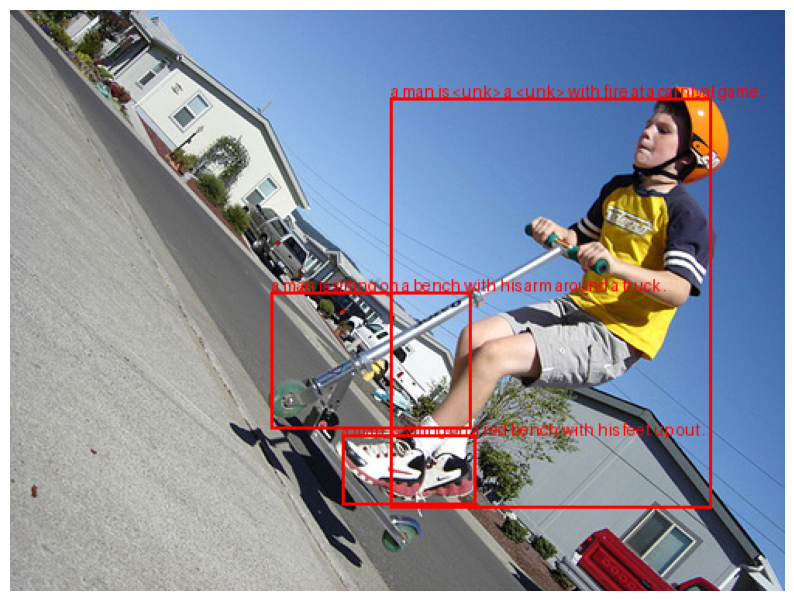

Box (245.9317169189453, 57.16090393066406, 452.2063293457031, 321.48486328125): a man is <unk> a <unk> with fire at a carnival game .
Box (214.15463256835938, 274.52874755859375, 300.9100036621094, 319.1291809082031): a man is sitting on a red bench with his feet up out .
Box (168.81289672851562, 182.32974243164062, 297.28125, 270.599853515625): a man is sitting on a bench with his arm around a truck .


In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

# Example test image
test_image = "data/Images/47870024_73a4481f7d.jpg"

# Generate region-level captions
final_image, region_caps = generate_region_captions(
    test_image,
    yolo_model,        # pretrained YOLOv5s
    gen_encoder_cnn,   # your generative encoder
    decoder_mrnn,      # trained decoder
    vocab,
    device
)

# Show the final annotated image
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.axis("off")
plt.show()

# Print each detected region caption
for box, cap in region_caps:
    print(f"Box {box}: {cap}")
